In [821]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os
import sympy
import control as ct
plt.rcParams.update({'font.size': 18})
IMAGES_FOLDER_PATH = os.path.join(os.path.dirname(os.path.abspath("main.ipynb")), 'tex/images')
np.set_printoptions(suppress=True,precision=2)

## 1. Синтез эталонного регулятора

Согласно варианту:

$$
 A = \begin{bmatrix} 0 & 1 \\ 1 & 4 \end{bmatrix} \hspace{5mm} b_0 = 4 \hspace{5mm} t_p = 0.2 \hspace{5mm} \bar{\sigma} = 0 \% \hspace{5mm} g(t) = sign(\sin{0.3t}) + 1.5 
$$

Рассмотрим полином Ньютона первого порядка: $\lambda^2 + 2w_0\lambda + w_0^2$  

In [822]:
A = np.array([
    [0., 1.],
    [1., 4.]
])
b = np.array([0., 4.]).T

In [823]:
def newthon_polynom(order, w_0):
    x = sympy.Symbol("x")
    num = np.ones(1)
    den = np.array(sympy.poly((x+w_0)**order).coeffs(), dtype=float)
    return ct.tf(num, den)

def compute_Am(t_p, sigma, x_0, delta = 0.01, order = 2):
    if sigma > 1:
        raise ValueError("Cannot handle case when sigma is more than 1. Use Butterworth polynomial instead.")
    
    w_0 = 1
    sys = newthon_polynom(order, w_0)
    t = np.linspace(0.0, 40.0, 1000)
    T, yout = ct.step_response(sys, T=t, X0=x_0)
   
    for i in range(1, len(yout)):
        if (abs(yout[-i] - 1.0) >= delta):
            break
        else:
            t_p_real = T[-i]

    w_0 = t_p_real / t_p

    Am = np.column_stack((np.zeros(order).T, np.eye(order)))[:, :-1]
    Am[-1] = -np.array(newthon_polynom(order, w_0).den).reshape(-1)[:0:-1]

    return Am

In [824]:
def goal_signal_generator(state, t, Am, bm, g):
    x = state
    dx = Am @ x + bm * g(t) 
    return dx

In [825]:
import matplotlib.patches as patches
from scipy import stats

In [826]:
def task1(y0, t, t_p, sigma, g, order, delta = 0.05):
    Am = compute_Am(t_p, sigma, y0, delta=delta, order=order)
    bm = np.append(np.zeros(order - 1), -Am[-1, 0]).T
    Cm = np.append(np.zeros(order - 1), 1)[::-1]
    p = (Am, bm, g)
    result = odeint(goal_signal_generator, y0, t, p)
   
    fig, axs = plt.subplots(1, 2, figsize=(12, 7))
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3,hspace=0.3)
   
    axs[0].plot(t, Cm @ result.T, color='r', label='$x_m$')
    axs[0].plot(t, g(t), color='b', label='$g(t)$')
    axs[0].grid()
    axs[0].set(xlabel='t, с', ylabel='x')
    axs[0].legend()

    start = 5
    end = 35
    stable_value = stats.mode(g(t)[start:end])[0]
    axs[1].plot(t[start:end], np.ones_like(t[start:end]) * (stable_value - delta), color='c', linestyle='--', label='delta neighborhood')
    axs[1].plot(t[start:end], np.ones_like(t[start:end]) * (stable_value + delta), color='c', linestyle='--')
    axs[1].fill_between(t[start:end], np.ones_like(t[start:end]) * (stable_value - delta), np.ones_like(t[start:end]) * (stable_value + delta), color='C0', alpha=0.3)   
    
    axs[1].plot(t[start:end], (Cm @ result.T)[start:end], color='r', label='$x_m$')
    axs[1].plot(t[start:end], g(t)[start:end], color='b', label='$g(t)$')
    axs[1].grid()
    axs[1].set(xlabel='t, с', ylabel='x')
    axs[1].legend()

 

    return result, Cm @ result.T

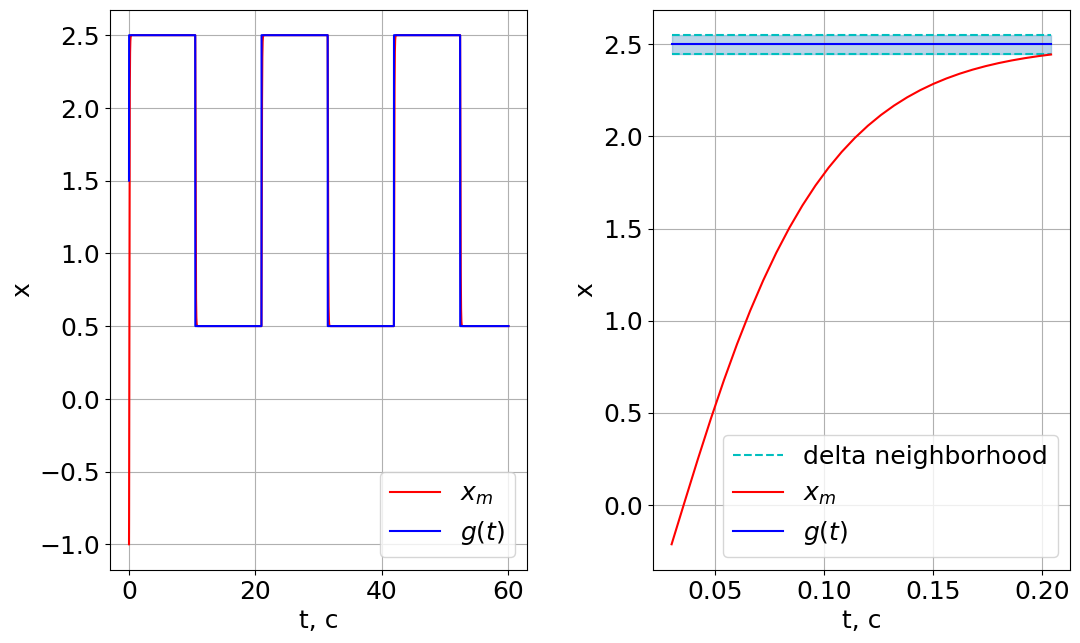

In [827]:

y0 = [-1.0, -1.0]
t = np.linspace(0.0, 60., 10000)
g = lambda t: np.sign(np.sin(0.3*t)) + 1.5
result, y = task1(y0, t, 0.2, 0, g, 2)

In [828]:
def u(t, theta, x, k, g):
    return theta.T @ x + 1. / k * g(t)

def comute_const_params(Am, A, b):
    am = -Am[-1, :]
    a = -A[-1, :]
    b = b[-1]
    theta = []
    for i in range(A.shape[0]):
        theta.append((-am[i] + a[i])/b)
    k = b / am[0]

    return np.array(theta), k

def modeling(state, t, order, fake_A, real_A, b, Am, bm, g):
    # state = np.array(state)
    x = state
    theta, k = comute_const_params(Am, fake_A, b)
    dx = real_A @ x + b * u(t, theta, x, k, g)
    # print(dx, dx_m, np.concatenate((dx, dx_m)))
    # return list(np.concatenate((dx, dx_m)))
    return dx

In [829]:
from copy import deepcopy

In [830]:
def task2(y0, t, t_p, sigma, g, order, delta = 0.05):
    Am = compute_Am(t_p, sigma, y0, delta=delta, order=order)
    bm = np.append(np.zeros(order - 1), -Am[1, 0]).T
    Cm = np.append(np.zeros(order - 1), 1)[::-1]
    fake_A = deepcopy(A)
    fake_A[1, 0] = -200


    fake_A[1, 1] = -10
    # print(fake_A, A)
    p = (2, fake_A, A, b, Am, bm, g)

    result = odeint(modeling, -np.array(y0), t, p)
    y = Cm @ result.T
    p = (Am, bm, g)
    result_goal = odeint(goal_signal_generator, y0, t, p)
    ym = Cm @ result_goal.T

    plt.plot(t, y, color='r', linewidth=2)
    plt.plot(t, ym, color='b', linestyle='--')

    return result, y, ym

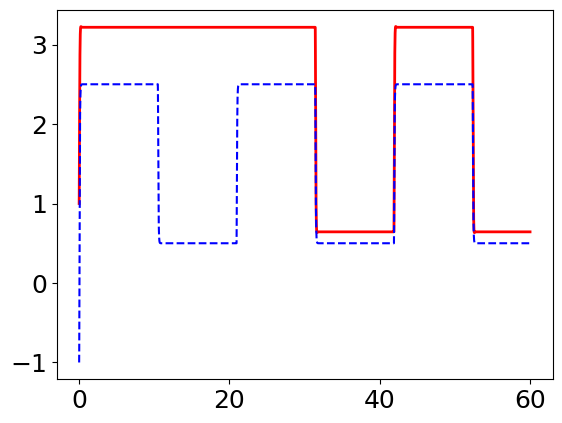

In [831]:
y0 = [-1.0, -1.0]
t = np.linspace(0.0, 60., 10000)
result, y, ym = task2(y0, t, 0.2, 0, g, 2)